In [76]:
#Imports
#Dataprep
import matplotlib.pyplot as plt #plots
import numpy as np 
from nilearn import datasets, plotting, image #plotting and example datasets
from nilearn.maskers import NiftiMapsMasker #testing with real data
from sklearn.decomposition import FastICA  #testing with real data
import pandas as pd #data preposcessing 
import tarfile #filehelper
import gzip #file helper
#GNN required
import torch
import torch.nn.functional as F
from torch.nn import Linear 
import torch.nn as nn
import torch_geometric 
from torch_geometric.nn import GCNConv #GCN method used for our model
from torch_geometric.nn import SAGEConv #usused type GCN
from torch_geometric.nn import GraphConv #GCN alternative
from torch_geometric.data import Data #Data tuple
from torch_geometric.loader import DataLoader
from torch.utils.data import SubsetRandomSampler #suffling
from sklearn.metrics import accuracy_score #calculate accuracy
import pingouin as pg # for data sim
import time #timing

### GNN setup

In [60]:
def collate(data_list):
    graphs, labels = map(list, zip(*data_list))
    return {
        'graph': graphs,
        'label': labels
    }

In [61]:
def edge_gen_treshold(netmat, treshold):
    mask = np.triu(abs(netmat) > treshold, k=1) # using only bottom triangle 
    edge_i = np.transpose(np.nonzero(mask))
    return torch.tensor(edge_i.T)

In [165]:
import random

In [191]:
class CorrelationDataset(torch.utils.data.Dataset):
    def __init__(self, netmats, labels, edges, split_ratio=(0.8, 0.1, 0.1)):
        self.netmats = netmats
        self.labels = labels
        self.edges = edges 
        self.split_ratios = split_ratio
        tot = len(self.netmats)
        train_samples = int(split_ratio[0] * tot)
        val_samples = int(split_ratio[1] * tot)
        
        #suffle
        indices = list(range(tot))
        random.shuffle(indices)
        
        # splits
        self.train_indices = indices[:train_samples]  # 0 - train_samples
        self.val_indices = indices[train_samples:train_samples + val_samples]
        self.test_indices = indices[train_samples + val_samples:]
        
    def __len__(self):
        return len(self.netmats)

    def __getitem__(self, idx):
        nmap = torch.tensor(self.netmats.iloc[idx]).float()
        edge_index = edge_gen_treshold(nmap, 0.5) # Change treshold here (two is great from testing)
        graph_data = Data(x=nmap, edge_index=edge_index)
        label = self.labels[idx]
        return graph_data, label
    
    def get_split(self, idx):
        if idx in self.train_indices:
            return 'train'
        elif idx in self.val_indices:
            return 'val'
        elif idx in self.test_indices:
            return 'test'
        else:
            raise ValueError('Index not in any split')

In [199]:
class GCN(nn.Module):
    def __init__(self, hidden_d):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(100, hidden_d)
        self.bn1 = nn.BatchNorm1d(hidden_d)
        self.conv2 = GCNConv(hidden_d, hidden_d)
        #self.bn2 = nn.BatchNorm1d(hidden_d)
        self.classifier = Linear(hidden_d, 1)

    def forward(self, data):
        data = data['graph'][0]
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.5)(x)
        x = self.conv2(x, edge_index)
        #x = self.bn2(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.5)(x)
        x = self.classifier(x).mean(dim=0)
        x = torch.sigmoid(x)
        return x

In [200]:
def train(model, data_loader, device, loss_fn, optimizer):
    model.train()
    total_loss = 0
    num_true = 0
    num_true_guesses = 0
    for d in data_loader:
        m = d['graph'][0]
        m = m.to(device)
        label = d['label'][0]
        optimizer.zero_grad() # zero the gradients 
        out = model(d).squeeze()
        loss = loss_fn(out.float(), label.float())
        loss.backward() #backprop
        optimizer.step() #update weights
        total_loss += loss.item()
        pred = (out.double() > 0.5).float()
        if pred == label.float():
            num_true += 1
        if pred == 1:
            num_true_guesses += 1
    return total_loss, num_true, num_true_guesses

def eval(model, loader, device):
    model.eval()
    cor = 0
    tot = len(loader)
    for d in loader:
        with torch.no_grad():
            out = model(d)
            pred = (out.float() > 0.5).float()
        y = d['label'][0]
        if pred == y:
            cor += 1
            
    return cor/tot

### From sim_correlation_gen

In [34]:
def gen_subject(func,func_args,num_f,b):
    w = func(np.arange(0,10,0.1),**func_args,b=b)
    df = gen_data_revised(w,100,num_features = num_f)
    return df

In [122]:
def gen_dist(func,func_args,num_f,num_each,b1,b2):
    df = pd.DataFrame(columns = ['gender', 'data', 'corr', 'pcorr', 'fcorr', 'fpcorr'])

    # gen m
    for i in np.arange(num_each):
        subject = gen_subject(func,func_args,num_f,b1)
        corr = subject.corr()
        pcorr = subject.pcorr()
        fcorr = apply_fisher(corr)
        fpcorr = apply_fisher(pcorr)

        df.loc[len(df.index)] = ['M',subject.to_numpy(),corr.to_numpy(),pcorr.to_numpy(),fcorr,fpcorr]

    # gen f
    for i in np.arange(num_each):
        subject = gen_subject(func,func_args,num_f,b2)
        corr = subject.corr()
        pcorr = subject.pcorr()
        fcorr = apply_fisher(corr)
        fpcorr = apply_fisher(pcorr)

        df.loc[len(df.index)] = ['F',subject.to_numpy(),corr.to_numpy(),pcorr.to_numpy(),fcorr,fpcorr]
    
    return df

In [123]:
def f3(x,b,f1,s1,f2,s2,f3,s3,amp,width):
    return amp*(f1*np.sin(s1*x)+f2*np.sin(s2*np.e*x)+f3*np.sin(s3*np.pi*x)) * \
           ((2*np.pi)**(-1/2)) * np.e**(-0.5*((x-b)/width)**2) + 1

In [124]:
arg100e = {'f1':1.9,'s1':3,'f2':6,'s2':5,'f3':4.5,'s3':1.3,'amp':0.1,'width':7}

In [125]:
num_f = 100
num_each = 500
b1 = 0
b2 = 0
func = f3
func_args = arg100e

In [126]:
def apply_fisher(data):
    numpied = data.to_numpy().copy()
    np.fill_diagonal(numpied, 0)
    return np.arctanh(numpied)

In [127]:
def gen_data_revised(active_weights,num_rows,num_features = 10,active_proportion = 0.4):
    # generate dataframe of gaussian noise
    df = pd.DataFrame(np.random.normal(1,0.1,size=(num_rows, num_features)))
    
    # split into active and inactive sets
    split_index = int(df[0].size * active_proportion)
    active, inactive = df.iloc[:split_index],df.iloc[split_index:]
    
    # multiply active set by diagonal matrix of weights
    active_mult = np.matmul(active,np.diag(active_weights))
    
    # join the two sets
    return pd.concat([active_mult,inactive])

In [128]:
dist0 = gen_dist(func,func_args,num_f,num_each,0,0)
dist2 = gen_dist(func,func_args,num_f,num_each,0,2)
dist4 = gen_dist(func,func_args,num_f,num_each,0,4)
dist6 = gen_dist(func,func_args,num_f,num_each,0,6)
dist8 = gen_dist(func,func_args,num_f,num_each,0,8)
dist10 = gen_dist(func,func_args,num_f,num_each,0,10)

In [129]:
dist0 = dist0[['gender', 'fpcorr']]
dist2 = dist2[['gender', 'fpcorr']]
dist4 = dist4[['gender', 'fpcorr']]
dist6 = dist6[['gender', 'fpcorr']]
dist8 = dist8[['gender', 'fpcorr']]
dist10 = dist10[['gender', 'fpcorr']]

In [83]:
torch.tensor(dist0.iloc[0].fpcorr).size()

torch.Size([100, 100])

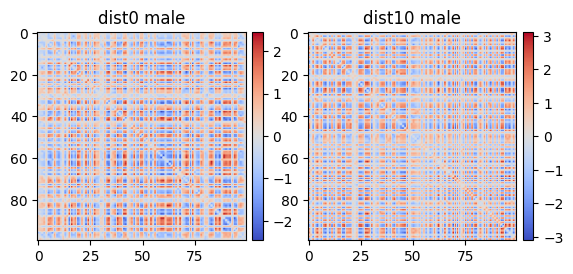

In [120]:
fig, (ax0, ax1) = plt.subplots(1,2)
c = ax0.imshow(torch.tensor(dist0.iloc[5].fpcorr), cmap='coolwarm')
fig.colorbar(c, ax=ax0, fraction=0.046, pad=0.03)
ax0.set_title('dist0 male')
c = ax1.imshow(torch.tensor(dist10.iloc[5].fpcorr), cmap='coolwarm')
ax1.set_title('dist10 male')
fig.colorbar(c, ax=ax1, fraction=0.046, pad=0.03)
plt.show()

### end of data sim

## dist tests

In [201]:
data_files = [dist0,dist2,dist4,dist6,dist8,dist10]
dist = 0
for data_file in data_files:
    netmats = data_file['fpcorr']
    labels = torch.tensor(data_file['gender'].replace({'M':0, 'F':1}))
    collate_fn = collate
    edges = None # No preset
    dataset = CorrelationDataset(netmats, labels, edges, split_ratio=(0.8, 0.1, 0.1))
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.train_indices), collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.val_indices), collate_fn=collate_fn)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.test_indices), collate_fn=collate_fn)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_dimensions = 150
    model = GCN(hidden_dimensions).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.BCELoss()
    num_epochs = 5
    start_time = time.time()
    for epoch in range(num_epochs):
        loss, num_true, num_true_guesses = train(model, train_loader, device, criterion, optimizer)
        train_results = eval(model, train_loader, device)
        val_results = eval(model, val_loader, device)
    end_time = time.time()
    train_eval_time = end_time - start_time
    print(f'dist{dist}, ' 
            f'Train: {100 * train_results:.2f}%, '
            f'Validation: {100 * val_results:.2f}%, '
            f'loss: {loss:.2f}, '
            f'Train and Eval time: {train_eval_time:.2f}s')
    dist += 2

dist0, Train: 67.12%, Validation: 50.00%, loss: 472.11, Train and Eval time: 98.41s
dist2, Train: 66.88%, Validation: 41.00%, loss: 469.54, Train and Eval time: 97.67s
dist4, Train: 66.00%, Validation: 40.00%, loss: 469.43, Train and Eval time: 94.88s
dist6, Train: 66.88%, Validation: 52.00%, loss: 467.94, Train and Eval time: 93.28s
dist8, Train: 69.88%, Validation: 55.00%, loss: 472.87, Train and Eval time: 98.20s
dist10, Train: 67.38%, Validation: 52.00%, loss: 456.51, Train and Eval time: 93.57s


In [195]:
class GCN(nn.Module):
    def __init__(self, hidden_d):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(100, hidden_d)
        self.bn1 = nn.BatchNorm1d(hidden_d)
        self.conv2 = GCNConv(hidden_d, hidden_d)
        #self.bn2 = nn.BatchNorm1d(hidden_d)
        self.classifier = Linear(hidden_d, 1)

    def forward(self, data):
        data = data['graph'][0]
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.5)(x)
        x = self.conv2(x, edge_index)
        #x = self.bn2(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.5)(x)
        x = self.classifier(x).mean(dim=0)
        x = torch.sigmoid(x)
        return x

In [196]:
data = dist8
netmats = data['fpcorr']
labels = torch.tensor(data['gender'].replace({'M':0, 'F':1}))
edges = None # No preset
dataset = CorrelationDataset(netmats, labels, edges, split_ratio=(0.8, 0.1, 0.1))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.train_indices), collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.val_indices), collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.test_indices), collate_fn=collate_fn)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dimensions = 150
model = GCN(hidden_dimensions).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

In [197]:
test = iter(train_loader)
print(next(test))

{'graph': [Data(x=[100, 100], edge_index=[2, 2968])], 'label': [tensor(0)]}


In [198]:
num_epochs = 5
for epoch in range(num_epochs):
        loss, num_true, num_true_guesses = train(model, train_loader, device, criterion, optimizer)
        train_results = eval(model, train_loader, device)
        val_results = eval(model, val_loader, device)
        avg_loss = loss / len(train_loader)
        print(f'Epoch: {epoch + 1}/{num_epochs}, '
          f'Loss: {loss}, '
          f'Avg Loss: {avg_loss:.3f}, '
          f'Train: {100 * train_results:.2f}%, '
          f'Validation: {100 * val_results:.2f}%, '
          f'Num Correct: {num_true}, '
          f'Num True: {num_true_guesses} ')

Epoch: 1/5, Loss: 561.6207367479801, Avg Loss: 0.702, Train: 53.62%, Validation: 55.00%, Num Correct: 405, Num True: 328 
Epoch: 2/5, Loss: 542.1018920242786, Avg Loss: 0.678, Train: 58.13%, Validation: 51.00%, Num Correct: 451, Num True: 378 
Epoch: 3/5, Loss: 527.7132107019424, Avg Loss: 0.660, Train: 62.25%, Validation: 51.00%, Num Correct: 482, Num True: 427 
Epoch: 4/5, Loss: 503.68002328276634, Avg Loss: 0.630, Train: 65.25%, Validation: 53.00%, Num Correct: 534, Num True: 445 
Epoch: 5/5, Loss: 479.46505753695965, Avg Loss: 0.599, Train: 66.50%, Validation: 54.00%, Num Correct: 553, Num True: 424 
